In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import concurrent.futures
n = 4
N = 10000

import os
#print(os.getcwd())
os.chdir('/home/vv/IsingModelPractice')


In [3]:
dataset = pd.read_csv("Data/Energy w All_4x4_flat.csv")

energies = dataset['energies'].to_numpy().astype(np.float32)
examples = dataset.iloc[:,1:n*n].to_numpy().astype(np.float32)

In [4]:
examples[1].dtype

dtype('float32')

In [5]:
N = int(dataset.shape[0])
n = int(np.sqrt(dataset.shape[1]-1))
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


def RFR_etimators(hypPar):
    num_of_trees = hypPar
    #training_size = num_of_trees_training_size[1]
    #testing_size = N - training_size
    X_train, X_test, y_train, y_test = train_test_split(examples, energies,train_size=15000, shuffle=True)
    model = RandomForestClassifier(n_estimators=num_of_trees)
    model.fit(X_train, y_train)
    
    
    
    return [num_of_trees, list(y_test), list(model.predict(X_test))]

args = list(np.arange(50,500,100))
eval_data = [[],[],[]]

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(RFR_etimators, [500])
    
    for p1 in results:
        eval_data[0].append(p1[0]) # number of trees
        eval_data[1].append(p1[1]) # training size
        eval_data[2].append(p1[2]) # OBB score
              

In [6]:
import random
train_rows = []
for i in range(15000):
    train_rows.append(random.randrange(65536))

#X_train, X_test, y_train, y_test = train_test_split(examples, energies, train_size=15000, shuffle=True)
X_train = []
y_train = []
for i in train_rows:
    X_train.append(examples[i])
    y_train.append(energies[i])

# This is stock without improvements
model = RandomForestRegressor(n_estimators=500)
model.fit(X_train, y_train)

In [10]:
X_train = []
y_train = []
for i in train_rows:
    X_train.append(examples[i])
    y_train.append(energies[i])

# attempts to get better results
model = RandomForestRegressor(n_estimators=500,oob_score=True,criterion="mse" )
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, oob_score=True)

In [11]:
print(model.oob_score_)
print(model.score(examples, energies))

0.797288215536486
0.7939672195180215


#### sklearn doesn't have a way to save and load models well
#### so all analysis is done here or by exporting data

In [14]:
posbl_abs_E = [0,4,8,12,16,20,24,32] #28 isn't possible
RFR_errs_per_E = {}

# creates a dictionary with empty list for every |E|
for i in posbl_abs_E:
    RFR_errs_per_E[i]=[]

# this chooses the closest class of predicted value
# i.e. regression to classification
def closest_abs_E(y_pred):
    acc = np.abs(y_pred)
    best = 0
    for i in posbl_abs_E:
        err = np.abs(i-np.abs(y_pred))
        if err <= acc:
            acc = err
            best = i
    return best

# this passes all of the data for testsing 
# for predicted E, append the error to corresponding list
# i.e. outcome is 15 lists with errors for given E 
y_pred_all = model.predict(examples)
for y_pred in y_pred_all:
    y_pred_class = closest_abs_E(y_pred)
    
    err = np.abs(energies[i]-y_pred)
    RFR_errs_per_E[y_pred_class].append(err)

    RFR_avg_err_per_E = []

for i in posbl_abs_E:
    if len(RFR_errs_per_E[i]) != 0:
        RFR_avg_err_per_E.append(sum(RFR_errs_per_E[i])/len(RFR_errs_per_E[i]))

In [15]:
abs_error = [np.abs(energies[i]-y_pred_all[i]) for i in range(65536)]

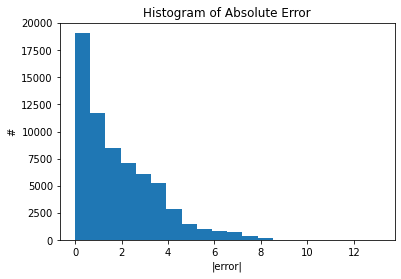

In [16]:
plt.hist(abs_error, bins=20)
plt.title("Histogram of Absolute Error")
plt.ylabel("#")
plt.xlabel("|error|")
plt.show()

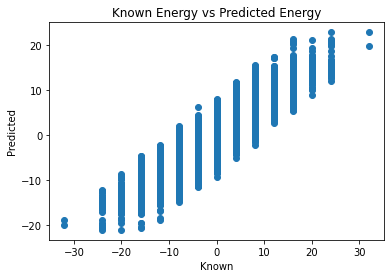

Note that the predicted is continuous, because regression


In [17]:
plt.scatter(energies, y_pred_all)
plt.title("Known Energy vs Predicted Energy")
plt.xlabel("Known")
plt.ylabel("Predicted")
plt.show()
print("Note that the predicted is continuous, because regression")

In [18]:

plt.bar(RFR_errs_per_E.keys(), RFR_avg_err_per_E)
plt.title("Average Error per |E|")
plt.xlabel("|E|")
plt.ylabel("Average error")
plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape

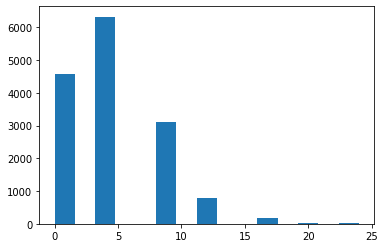

In [19]:
plt.hist([abs(i) for i in y_train], bins=15)
plt.show()

# 500 trees

import time
start_time = time.time()#time

X_train5, X_test5, y_train5, y_test5 = train_test_split(examples, energies,train_size=0.8, test_size=0.2)
model5 = RandomForestClassifier(n_estimators=500, oob_score = True)
model5.fit(X_train, y_train)


train_time = time.time() - start_time#time
print("--- %s seconds ---" % train_time)#time
train_time5 = round(train_time, 3)

# 700 trees

import time
start_time = time.time() #time

X_train7, X_test7, y_train7, y_test7= train_test_split(examples, energies,train_size=0.8, test_size=0.2)
model7 = RandomForestClassifier(n_estimators=700, oob_score = True)
model7.fit(X_train, y_train)


train_time = time.time() - start_time #time
print("--- %s seconds ---" % train_time)#time
train_time7 = round(train_time, 3)

# 500 trees

start_time = time.time() #time

y_new5 = model5.predict(X_test5)


predi_time = time.time() - start_time #time

print("--- %s seconds ---" % predi_time) #time
predi_time5 = round(predi_time, 3)


# 700 trees

start_time = time.time() #time

y_new7 = model7.predict(X_test7)


predi_time = time.time() - start_time #time

print("--- %s seconds ---" % predi_time) # time
predi_time7 = round(predi_time, 3)


error2 = []

for i in y_test:
    for j in  y_new:
        error2.append(abs(i-j))



print(error2[0:10])

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, constrained_layout=True)

counts5, edges5, plot5 = axs[0].hist(abs(y_test5-y_new5), bins = 12, color='darkslateblue')
counts5=[int(i) for i in counts5]

axs[0].set_title(f"500 tree; train-t {train_time5}, predicting-t {predi_time5}")
axs[0].set_xlabel(f'|error|; # of 0\'s= {counts5[0]}, 4\'s= {counts5[4]}, 8\'s= {counts5[8]}, 12\'s= {counts5[11]}')
axs[0].set_ylabel('#')
fig.suptitle('n_subplots comparison', fontsize=16)


counts7, edges7, plot7 = axs[1].hist(abs(y_test7-y_new7), bins = 12, color='darkslateblue')
counts7=[int(i) for i in counts7]

axs[1].set_xlabel(f'|error|; # of 0\'s= {counts7[0]}, 4\'s= {counts7[4]}, 8\'s= {counts7[8]}, 12\'s= {counts7[11]}')
axs[1].set_title(f"700 tree; train-t {train_time7}, predicting-t {predi_time7}")
axs[1].set_ylabel('#')
plt.show()

